## Sensitivity of the analysis with respect to the coverage
### **Rev1.1** 
*Perform an analysis to test how sensitive your results are to the number of reads per sample that are required to retain a site in the analysis (currently only 5 reads on average). In the discussion section you state that your high coverage could explain why your "modest" sample size detects so many caQTLs. However, another reason could be that many of these are false positives. I agree that you have high coverage per sample, which is great, but to then only require 5 reads on average to retain a site means that many will have poor coverage and this will be detrimental to the allele-specific analysis*

In [4]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2')

library(repr)

longf = read.table('summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv', header=T)
genotypes = read.table('example_boxplots/All_tested_genotypes.tsv', header=T, row.names=1)

longf$exclude = longf$Sequencing_mapping_error_rate>0.1 | longf$Ref_allele_bias<0.2 | longf$Ref_allele_bias>0.8

bc = c('b', "t",'mono',  'nk')

cs =  c("bulk", bc, 
   as.character(read.table("/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/color_scheme.tsv")[1:15,2]))

cells = data.frame(celltypes = cs, type = c("bulk", rep("broad", 4), rep("fine", 15)))

main      = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/'


In [5]:
cellypes_original_order =  as.character(cells[,1]) 

In [6]:
reorder = c(1,6, 11,16,2,7,12,17,3,8,13,18,4,9,14,19,5,10,15,20)
cells = cells[reorder,]

In [14]:
means=data.frame()
#options(repr.plot.width=15, repr.plot.height=8)
pdf("figures/Effect_of_coverage_excluded_large.pdf", height = 15, width = 10)
par(mfcol = c(8,5), mar =c(2,4,3,1))
for(i in 1:nrow(cells)){
#for(i in 1){
ce    =   as.character(cells[i,1])  
home  =   paste0(main, as.character(cells[i,2]), "/"  )    
peaks =   read.table(paste0(home, ce,"/",ce, ".count_matrix" ), header=T, stringsAsFactors = F, row.names = 1)

colnames(peaks)[6:15] = colnames(genotypes)
res = subset(longf, cell==ce)
res_sig = subset(res, flag_fdr10==TRUE & exclude==FALSE)
ro = rowMeans(peaks[,6:15])
rm  = rowMeans(peaks[as.character(res$Feature),6:15])
rms = rowMeans(peaks[as.character(res_sig$Feature)  ,6:15])
m =merge(res[,c("Feature", "varID")], peaks [,6:15], by.x=1, by.y="row.names")
gt = genotypes
gt[gt!=1]<-NA
m = merge(m, gt, by.x=2, by.y="row.names")    
rmh = apply(m[,3:22], 1, function(x) mean(as.numeric(x[1:10]/x[11:20]), na.rm=T))
rmsh = apply(m[ m$Feature %in% as.character(res_sig$Feature),3:22], 1, function(x) mean(as.numeric(x[1:10]/x[11:20]), na.rm=T))

li = list(ro,rm, rmh,rms, rmsh)


boxplot(li, outline=F, col="gray30", ylab="avg.coverage",
        names=c("all", "tested", "test.het", "signif.", "sig.het"), las=3)
text(x=1:5, y= lapply(li, median), 
     labels = round(as.numeric(lapply(li, median))), col="green", font=2)
mtext(ce)
se = seq(0,round(max(rms))+10,by=10)
hist(rms, xlab="Average peak coverage of caQTLs", main = NA, breaks=se, col =c("red", rep("gray",length(se) )))
pct = round(sum(rms<=10)/length(rms),2 )*100
mtext( paste0("N.lo.cov\n" , sum(rms<=10), " (",pct , "%)"), col="red", line=-4,adj = 1 , cex=0.8)           
mtext("Avg. coverage caQTLs", side=1, cex=0.8, line=2)             

             
means = rbind(means,as.numeric(lapply(li, median)) )            
             
         }
   dev.off()

png 
  2

In [15]:
colnames(means) = c("all", "tested", "test.het", "signif.", "sig.het")
rownames (means) = cells[,1]

In [16]:
summary(means$signif./means$tested)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7692  1.3446  1.6168  1.6028  1.8257  3.2871 

In [10]:
summary(means$signif./means$tested)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8696  1.0140  1.0893  1.1540  1.2489  1.6825 

The figure shows the distrubutions of the **mean coverage** of peaks between the samples in the orignal peak set, the tested peak set (filtered at 5), and the significant caQTL peaks, in either all samples or only heterozygous when indicated. In green the **median** of the distribution. Significant caQTLs (last 2 boxplots) have a higher meedian coverage, as expected so in order to reach higher power. Although we cannot exclude that low coverage peaks might give false positive results, these are not the bulk of our results.  

Note : Increasing the cutoff for mean coverge from 2 to 5 reads had actually a dramamatic effect in increasing (+20%) the number of caQTLs indentified (opposite as the reviewer said), likely because there are fewer test for fdr correction.

### **Rev1.2** 
*Filter out variants with Phi<0.2 or Phi>0.8 as well as Delta>0.1 (RASQUAL QC metrics) to help guard against genotyping error in the ASE analysis*

In [5]:
celltypes = as.character(cells[,1])

In [6]:
lf_sig = droplevels(subset(longf, flag_fdr10==TRUE & cell %in%celltypes))
sp = split(lf_sig, lf_sig$cell)
me=sapply(sp, function(x) sum(x$Sequencing_mapping_error_rate>0.1))

In [7]:
me

act_cd4_t adaptive_NK           b        bulk         cDC       cMono 
          3           0           0           0           0           3 
 cyto_cd8_t     cyto_nk       iMono       mem_b   mem_cd8_t         mkc 
          0           0           0           0           0           0 
       mono     naive_b naive_cd4_t naive_cd8_t      ncMono          nk 
          3           0           0           1           0           0 
          t        tReg 
          2           0

In [8]:
phi=sapply(sp, function(x) sum(x$Ref_allele_bias<0.2 | x$Ref_allele_bias>0.8))

In [14]:
summary(lf_sig$Ref_allele_bias)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06144 0.43476 0.50000 0.50062 0.56852 0.88487 

In [9]:
phi

act_cd4_t adaptive_NK           b        bulk         cDC       cMono 
          4           0           2          41           0          16 
 cyto_cd8_t     cyto_nk       iMono       mem_b   mem_cd8_t         mkc 
          3           5           1           0           0           0 
       mono     naive_b naive_cd4_t naive_cd8_t      ncMono          nk 
         18           1           1           0           2           6 
          t        tReg 
         14           0

In [11]:
sum(lf_sig$exclude)

[1] 126

In [12]:
dim(lf_sig)

[1] 20094    32

In [13]:
126/20094

[1] 0.006270529

In [15]:
sum(!duplicated(lf_sig$Feature))

[1] 8184

In [16]:
sum(!duplicated(lf_sig$Feature[lf_sig$exclude==FALSE]))

[1] 8168

In [18]:
sum(!duplicated(lf_sig$Feature[lf_sig$cell!="bulk"]))

[1] 6916

In [19]:
sum(!duplicated(lf_sig$Feature[lf_sig$cell!="bulk"  & lf_sig$exclude==FALSE]))

[1] 6901

In [20]:
1- (6901/6916)

[1] 0.002168884

Only few caQTLs had DELTA >0.1, and  phi between 0.2 and 0.8. 

In [79]:
#options(repr.plot.width=12, repr.plot.height=8)
pdf("figures/effect_size.pdf")
par(mfcol = c(4,5), mar=c(4,2,3,1))
for(ce in celltypes){
res = subset(longf, cell==ce)
res_sig = subset(res, flag_fdr10==TRUE)
hist(res_sig$Effect_size, main = ce, xlab="Effect (Phi)", 
     breaks=seq(0,1,by=0.1), col =c("red", "red", rep("gray", 6), "red", "red"))
mtext(paste0("n=", sum(res_sig$Effect_size<0.2 | res_sig$Effect_size>0.8)), col="red", at = 0.7, cex=0.7)
mtext(paste0("n=", sum(res_sig$Effect_size>=0.2 & res_sig$Effect_size<=0.8)), col="gray20", at = 0.3, cex=0.7)

}
dev.off()

png 
  2

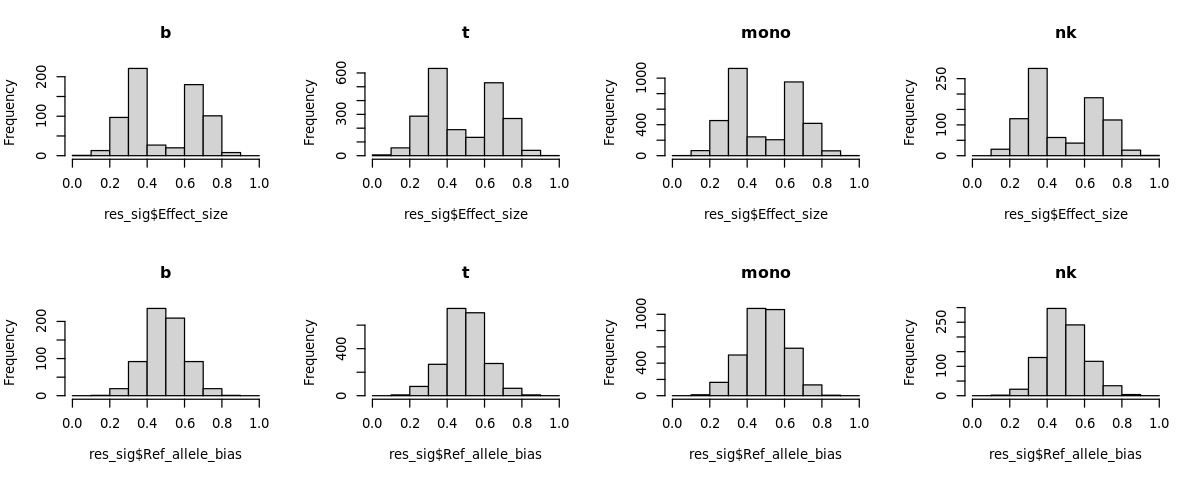

In [2]:
options(repr.plot.width=10, repr.plot.height=4)
par(mfcol = c(2,4))
for(ce in bc){
res = subset(longf, cell==ce)
res_sig = subset(res, flag_fdr10==TRUE)
hist(res_sig$Effect_size, main = ce,  breaks=seq(0,1,by=0.1), xlim=c(0,1))
hist(res_sig$Ref_allele_bias, main = ce,  breaks=seq(0,1,by=0.1), xlim=c(0,1))

}

In [75]:
#options(repr.plot.width=12, repr.plot.height=8)
pdf("figures/effect_size_by_coverage.pdf")
par(mfcol = c(4,5), mar =c(2,4,4,1))
for(i in 1:nrow(cells)){
 #for(i in 1){   
ce    =   as.character(cells[i,1])  
home  =   paste0(main, as.character(cells[i,2]), "/"  )    
peaks =   read.table(paste0(home, ce,"/",ce, ".count_matrix" ), header=T, stringsAsFactors = F, row.names = 1)

colnames(peaks)[6:15] = colnames(genotypes)
res = subset(longf, cell==ce)
res_sig1 = subset(res, flag_fdr10==TRUE & Effect_size>= 0.2 & Effect_size <= 0.8 )
rms1 = rowMeans(peaks[as.character(res_sig1$Feature)  ,6:15])
res_sig2 = subset(res, flag_fdr10==TRUE & (Effect_size < 0.2 | Effect_size> 0.8) )
rms2 = rowMeans(peaks[as.character(res_sig2$Feature)  ,6:15])

li = list(rms1, rms2)
boxplot(li, outline=T, col="gray30", names=c("mi", "hi"), las=3, 
        ylab="average coverage", main=ce)
#text(x=1:2, y= lapply(li, median), 
#     labels = round(as.numeric(lapply(li, median))), col="green")

if(length(rms1)>3 & length(rms2)>3)   { 
    mtext (paste("p=",signif(wilcox.test(rms1, rms2)$p.value,2),c("", "*")[(wilcox.test(rms1, rms2)$p.value<0.05)+1]),
       line=-1.2, cex=0.8)}
mtext(round(as.numeric(lapply(li, median))), at =c(1,2), cex=0.8)     
             }
dev.off()

Warning message in wilcox.test.default(rms1, rms2):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(rms1, rms2):
“cannot compute exact p-value with ties”


png 
  2

Extreme effect do not seem driven by very low coverage

### **Rev1.3** 
*Report how many caQTLs are detected at higher FDR of 0.05 and 0.01*

In [21]:
dim(longf)

[1] 1133379      32

In [26]:
head(longf[,c(27:29,30,31)])

,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude
,<lgl>,<lgl>,<lgl>,<chr>,<lgl>
1,TRUE,TRUE,TRUE,b,FALSE
2,TRUE,TRUE,TRUE,b,FALSE
3,TRUE,TRUE,TRUE,b,FALSE
4,TRUE,TRUE,TRUE,b,FALSE
5,TRUE,TRUE,TRUE,b,FALSE
6,TRUE,TRUE,TRUE,b,FALSE


In [27]:
ap = apply(longf[,c(27:29,31)], 1, function(x)  x[1:3]*!x[4])
ap2 = as.data.frame(t(as.matrix(ap)))
ap2$cell= longf$cell

In [28]:
ag = aggregate( list(ap2$flag_fdr10,ap2$flag_fdr05,ap2$flag_fdr01), by= list(ap2$cell,ap2$cell,ap2$cell) ,sum)

In [29]:
df = ag[,4:6]

In [30]:
rownames(df) = ag[,1]

In [34]:
agg2 = aggregate(Feature~cell, longf, length)

In [38]:
df = cbind(df, agg2[,2])

In [39]:
df = df[cellypes_original_order,]

In [41]:
colnames(df) = c( 'caQTL_fdr10%',  'caQTL_fdr05%', 'caQTL_fdr01%', "Tested features")

In [42]:
df

,caQTL_fdr10%,caQTL_fdr05%,caQTL_fdr01%,Tested features
,<int>,<int>,<int>,<int>
bulk,4662,3028,1121,194846
b,666,369,156,45013
t,2128,1389,464,97382
mono,3507,2135,637,128198
nk,841,501,117,51945
cMono,2941,1773,571,116192
ncMono,486,311,101,54300
iMono,42,22,13,35454
cDC,72,55,36,24092


## Sample size bias
### Rev3.1
Sample size. The study population consists of 10 individuals, of which 2 appear to be from a different ethnic background (see #2). The statistical test used to detect caQTL is implements in RASQUEL, which has a regression step where the total fragment count (Yi) is regressed against the number of alternative SNP alleles (i.e. 0, 1, 2). As reported in the manuscript a filtering step is employed where only SNPs with 2+ individuals carrying heterozygous genotype classes are included. However, this presumably removed most SNPs within a given region? For example, even at MAF = 0.1, under HWE, the average number of het individuals = 1.8, while the common homozygous = 0.1. But most importantly, under this filtering, maf needs to be greater than 0.3 before we would expect to observe a single individual carrying the rare homozygous class, and 0.45 before there are two. Thus, for the vast majority of SNPs tested, the regression model will only have two observed classes, and considerable imbalance between them. The adjusted Yi from that model is thus likely to be biased. This possibly explains the very large number of caQTL detected given the sample size. For example, in LCLs with >2.5x larger sample size, approximately halve the number of caQTLs are detected.
The simplest suggestion to resolve this problem is to increase sample size, although I acknowledge the challenges in doing so. In the absence of this, I think it is important that the biases associated with lower sample size (i.e. n of allele class, and inaccurate estimations of means) is deeply evaluated and addressed. One starting point would be to use simulations to best the error rates under a range of true null (i.e. no genetic effects) scenarios. Using a inflation statistic such as lambda from a QQ plot might be a helpful way to demonstrate this. Assuming that you identify an inflation in the test statistic under the null (for some scenarios), then applying this to correct the original tests might help differentiate artifacts from true signals.

 *QQPlots for 2 and 3 genotypes*

In [5]:
library(data.table)

In [7]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2')

library(repr)

longf = read.table('summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv', header=T)
genotypes = read.table('example_boxplots/All_tested_genotypes.tsv', header=T, row.names=1)


In [41]:
qqplotf = function(pvalues, title, colr ="black", add=FALSE){
coaccP = sort(-log(pvalues, 10))
set.seed(1)
uniP = runif(length(coaccP))
uniP = sort(-log10(uniP))
chisq <- qchisq(1-pvalues,1)
lgc = median(chisq)/qchisq(0.5,1)

if(add == FALSE){
plot(uniP, coaccP, pch=20, cex=0.6, col=colr,
     xlab="Theoretical -Log10(P)", ylab="-Log10(P) caQTLs", main =title)
abline(0,1)
#mtext(paste("Lgc=", round(lgc,2), "Pm=", round(median(pvalues),3)))  
#mtext("-" , col = colr, adj = 0, cex=2)    
    } else if (add == TRUE){
 points(uniP, coaccP, pch=20, cex=0.6, col=colr)
# mtext(paste("Lgc=", round(lgc,2), "Pm=", round(median(pvalues),3)), line=-1.5)    
# mtext("-" , col = colr, adj = 0, line=-1.5, cex=2)   
}
               }

In [9]:
ngt = sapply(1:nrow(genotypes), function(x) length(table(t(genotypes[x,]))))

In [10]:
table(ngt)

ngt
     1      2      3 
    68 101312  89736 

In [46]:
101312/ (101312+89736)
89736/ (101312+89736)

[1] 0.5302961

[1] 0.4697039

The number of SNPs witth 2 and 3 genotypes are not vastly different --- 13% more SNPs with 2 genotypes, while the reviewer said that 2 genotypes would be the vast majority

In [12]:
cellypes = c('bulk','b','t','mono','nk')

In [51]:
home = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/broad/"

In [53]:
dist_gt = data.frame(
zero = rowSums(genotypes==0),
one  =  rowSums(genotypes==1),
two  = rowSums(genotypes==2)
)

In [54]:
test = as.data.frame(table(dist_gt))

In [55]:
test = test[order(test$Freq, decreasing=T),]
test = subset(test, Freq!=0)

In [56]:
lbs = apply(test[,1:3], 1,paste, collapse ="|")
ng  = rowSums(test[,1:3]==0)+1

In [57]:
#options(repr.plot.width=10, repr.plot.height=10)
#plot(1:nrow(test), test$Freq, las =2, pch = 16, xlab="Rank", ylab="Frequency", col =ng)
#text(1:nrow(test), test$Freq, labels= lbs, pos=4,srt=45 , col=ng)

In [58]:
head(test)

,zero,one,two,Freq
,<fct>,<fct>,<fct>,<int>
9,8,2,0,31516
17,7,3,0,20014
25,6,4,0,13279
33,5,5,0,8163
97,6,3,1,7287
105,5,4,1,7179


In [59]:
test$lbs1 = lbs
test$lbs2 = apply(test[,3:1], 1,paste, collapse ="|")
mg        = merge(test, test, by.x = 'lbs2', by.y="lbs1")
mg        = mg[-1,]
mg$tot    = mg$Freq.x+mg$Freq.y
mg$lbstot = paste(mg$lbs1, mg$lbs2, sep="+")
mg        = mg[order(mg$tot, decreasing = T),]
mg        = mg[!duplicated(mg$tot),]

In [60]:
#options(repr.plot.width=10, repr.plot.height=5)
pdf("figures/distribution_genotypes.pdf")
par(mfrow=c(2,1), mar=c(2,2,2,2))
barplot( test$Freq, las =2, ylab="Frequency", names.arg = test$lbs1,cex.names=0.8,
         col = rowSums(test[,1:3]==0)+1)
legend("topright", pch=15, col=2:1, legend=c("2GT", "3GT"),cex=1.5)
dev.off()

png 
  2

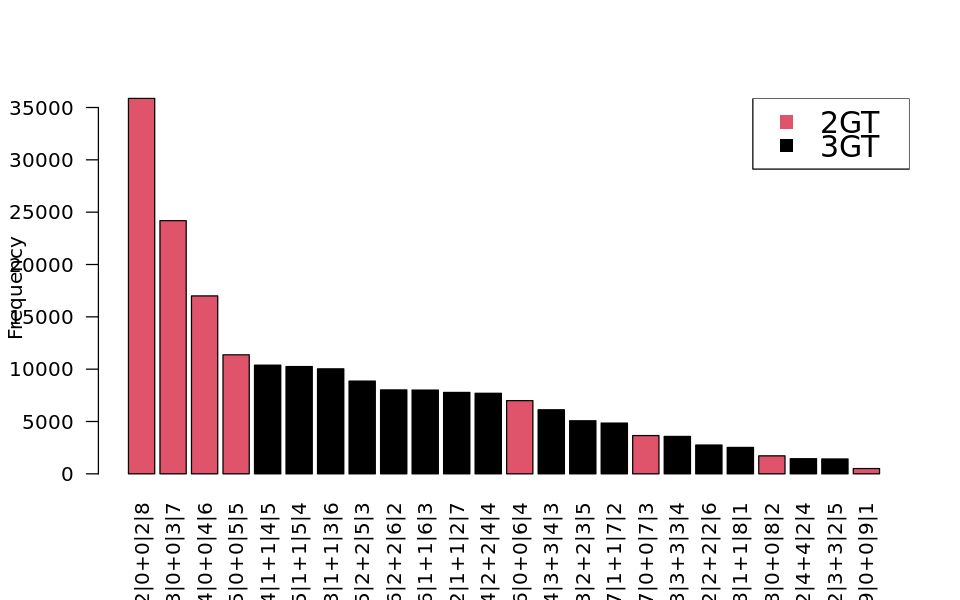

In [61]:
options(repr.plot.width=8, repr.plot.height=5)
barplot( mg$tot, las =2, ylab="Frequency", names.arg = mg$lbstot,
         col = rowSums(mg[,2:4]==0)+1)
legend("topright", pch=15, col=2:1, legend=c("2GT", "3GT"),cex=1.5)

In [62]:
cms = cumsum(mg$tot)

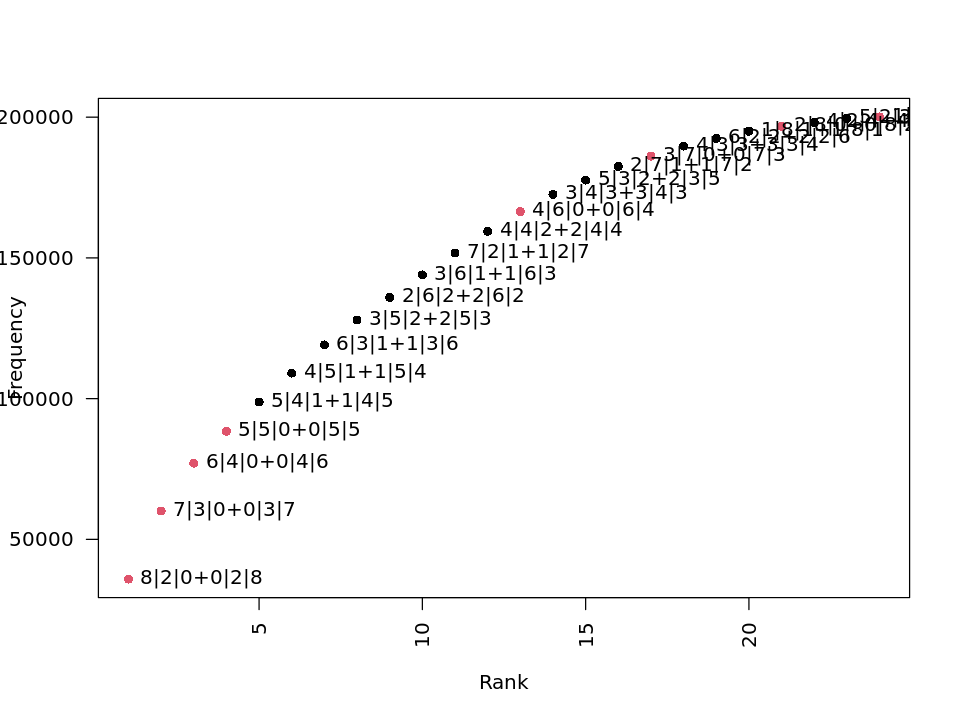

In [63]:
options(repr.plot.width=8, repr.plot.height=6)
plot(1:nrow(mg), cms, las =2, pch = 16, xlab="Rank", ylab="Frequency", 
     col = rowSums(mg[,2:4]==0)+1)
text(1:nrow(mg), cms, labels= mg$lbstot, pos=4)

In [64]:
lba = apply(dist_gt[,1:3], 1,paste, collapse ="")
lbb = apply(dist_gt[,3:1], 1,paste, collapse ="")
unicat = sapply(1:length(lba), function(x) max(as.numeric(lba[x]), as.numeric(lbb[x])))

In [65]:
### a quicker way to do the same things as above
table(unicat)

unicat
  100   181   190   262   271   280   343   352   361   370   424   433   442 
   68  1263   508  4010  4852  1720  3061  8860  8002  3657   724  3574  7694 
  451   460   523   532   541   550   622   631   640   721   730   820 
10248  6996  1424  5074 10383 11373  2754 10033 16999  7780 24189 35870 

In [66]:
longf$gtcat = unicat[ match(longf$varID,rownames(dist_gt))]

In [67]:
longf$two = grepl(0, longf$gtcat)

In [68]:
#options(repr.plot.width=10, repr.plot.height=15)
pdf("figures/barlots_enrichment_genotypes.pdf")
par (mfrow=c(5,2), mar=c(2,4,3,0))
for(ce in cellypes_original_order[1:5]){
res  = subset(longf, cell==ce)
fish = data.frame()
for(cats in na.omit(unique(res$gtcat))){
    
    tb = table(res$gtcat==cats, (res$flag_fdr10==TRUE & res$exclude==FALSE))
     fish = rbind(fish,c(unlist(fisher.test(tb)[c(1,3)]),tb[2,2]))
}
rownames(fish) = na.omit(as.character(unique(res$gtcat)))
colnames(fish) = c("pv", "or", "n")
fish$col = grepl("0", rownames(fish))+1
fish = fish[order(fish$or, decreasing=T),]
fish = subset(fish, rownames(fish)!="100")

bp=barplot( fish$or, las =2, ylab="Enrichment in caQTLs", names.arg = rownames(fish),cex.names = 1,
            col = fish$col, cex.axis=1 , main=ce)
#legend("topright", pch=15, col=2:1, legend=c("2GT", "3GT"))
text(x=bp, y=fish$or,  labels= c("","*")[(fish$pv<0.05)+1], cex=2, pos=3)
abline(h=1, col=5, lwd=2)
barplot( fish$n, las =2, ylab="caQTL counts", , cex.axis=1,cex.names=1,
        names.arg = rownames(fish), col = fish$col)
}
dev.off()

png 
  2

We can definitely say that caQTLs tend to have many het ppl and 3 genotypes rather than only 2 genotypes with few hets (most common gt 820 and 730). This is also consistent with the fact that performing the qtl only with pop data and not allelic imbalance does not give significant results (we have to remind that to the reviewers) -as we repoted in the paper. Once again the power is in ASE.

In [69]:
fish = data.frame()
for(ce in cellypes_original_order){
res  = subset(longf, cell==ce)

    
    tb = table(!(res$two), (res$flag_fdr10==TRUE & res$exclude==FALSE))
     fish = rbind(fish,c(unlist(fisher.test(tb)[c(1,3)]),tb[2,2]))

}

In [70]:
colnames(fish)=c("pval", "OR", "n")
rownames(fish)=cellypes_original_order

In [71]:
fish

,pval,OR,n
,<dbl>,<dbl>,<dbl>
bulk,1.631987e-02,1.073958,2439
b,8.968108e-21,2.104515,424
t,1.032470e-33,1.704967,1245
mono,1.097739e-50,1.674356,2041
nk,1.079867e-18,1.860329,510
cMono,3.361676e-48,1.731527,1742
ncMono,3.247313e-13,1.963188,304
iMono,4.407093e-01,1.292686,22
cDC,4.513325e-06,3.185871,53


overall two genotypes are depleted over 3gt are enriched among QTLs

In [18]:
sum(!duplicated(longf$Feature[longf$cell!='bulk']))

[1] 157131

In [32]:
sum(!duplicated(longf$Feature[longf$cell!='bulk' & longf$flag_fdr10==TRUE & longf$exclude==FALSE]))
length(longf$Feature[longf$cell!='bulk' & longf$flag_fdr10==TRUE & longf$exclude==TRUE])

[1] 6901

[1] 85

In [33]:
length(longf$Feature[  longf$flag_fdr10==TRUE])
length(longf$Feature[ longf$flag_fdr10==TRUE & longf$exclude==TRUE])

[1] 20094

[1] 126

In [30]:
length(unique(longf$Feature[longf$cell!='bulk' & longf$flag_fdr10==TRUE]))
length(unique(longf$Feature[longf$cell!='bulk' & longf$flag_fdr10==TRUE & longf$exclude==TRUE]))

[1] 6916

[1] 55

In [29]:
85/15391

[1] 0.005522708

In [34]:
126/20094

[1] 0.006270529

In [31]:
55/6916

[1] 0.007952574

In [25]:
6901/ 157131

[1] 0.04391877

In [35]:
subsig = subset(longf,flag_fdr10==T & exclude==F & cell!="bulk" )

In [40]:
mean(table(subsig$cell))

[1] 805.5789

In [41]:
median(table(subsig$cell))

[1] 486

In [42]:
table(subsig$cell)


  act_cd4_t adaptive_NK           b         cDC       cMono  cyto_cd8_t 
       1341          41         666          72        2941         622 
    cyto_nk       iMono       mem_b   mem_cd8_t         mkc        mono 
        741          42         163         228          31        3507 
    naive_b naive_cd4_t naive_cd8_t      ncMono          nk           t 
        390         653         336         486         841        2128 
       tReg 
         77 